In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from pathlib import Path
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime
import numpy as np


# Dependency imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Notebook Extentions
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
print(np.__version__)

1.20.1


# CNN Model

### CNN Model Prep

In [2]:
X_train = np.load('data/japanese_X_train.npz')['arr_0']
X_val = np.load('data/japanese_X_validation.npz')['arr_0']
y_train = np.load('data/japanese_y_train.npz')['arr_0']
y_val = np.load('data/japanese_y_validation.npz')['arr_0']

In [3]:
# Image dimensions
img_row, img_col = 64, 64

# Classes
japanese_class = 3

In [4]:
# Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    japanese_X_train = X_train.reshape(X_train.shape[0], 1, img_row, img_col)
    japanese_X_val = X_val.reshape(X_val.shape[0], 1, img_row, img_col)
    japanese_shape = (1, img_row, img_col) 
else:
    japanese_X_train = X_train.reshape(X_train.shape[0], img_row, img_col, 1)
    japanese_X_val = X_val.reshape(X_val.shape[0], img_row, img_col, 1)
    japanese_shape = (img_row, img_col, 1)

In [5]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = japanese_shape, data_format = 'channels_last'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(japanese_class, activation = 'softmax'))

In [6]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [7]:
# Callbacks
japanese_es = EarlyStopping(patience = 5, verbose = 1, restore_best_weights = True)
japanese_lr = ReduceLROnPlateau(factor = 0.5, patience = 3, verbose = 1)

# Tensorboard Callback
japanese_log_dir = 'logs/CNN/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = japanese_log_dir, histogram_freq = 1)

### Adding Variation with ImageDataGenerator
- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D CNN

In [8]:
japanese_X_val.shape

(34552, 64, 64, 1)

In [9]:
japanese_X_train.shape

(138204, 64, 64, 1)

In [10]:
y_val.shape

(34552, 3)

### CNN Model Run

In [11]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.2)
datagen.fit(japanese_X_train)

cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

cnn_results = cnn_model.fit(datagen.flow(japanese_X_train, y_train, batch_size = 32),
          epochs = 30, callbacks = (japanese_es, japanese_lr, tensorboard_callback), validation_data = (japanese_X_val, y_val))

Epoch 1/30
   1/4319 [..............................] - ETA: 0s - loss: 1.1000 - accuracy: 0.2188WARNING:tensorflow:From C:\Users\Administrator\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4319/4319 [==============================] - 1081s 250ms/step - loss: 0.0660 - accuracy: 0.9755 - val_loss: 0.0239 - val_accuracy: 0.9915
Epoch 2/30
4319/4319 [==============================] - 1062s 246ms/step - loss: 0.0337 - accuracy: 0.9885 - val_loss: 0.0154 - val_accuracy: 0.9947
Epoch 3/30
4319/4319 [==============================] - 1052s 244ms/step - loss: 0.0238 - accuracy: 0.9919 - val_loss: 0.0118 - val_accuracy: 0.9961
Epoch 4/30
4319/4319 [==============================] - 1054s 244ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0088 - val_accuracy: 0.9972
Epoch 5/30
4319/

In [12]:
cnn_model.save('models/cnn_model.h5')

### CNN Model Evaluation

In [13]:
cnn_history = cnn_results.history
cnn_training_loss = cnn_history['loss']
cnn_val_loss = cnn_history['val_loss']
cnn_training_accuracy = cnn_history['accuracy']
cnn_val_accuracy = cnn_history['val_accuracy']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

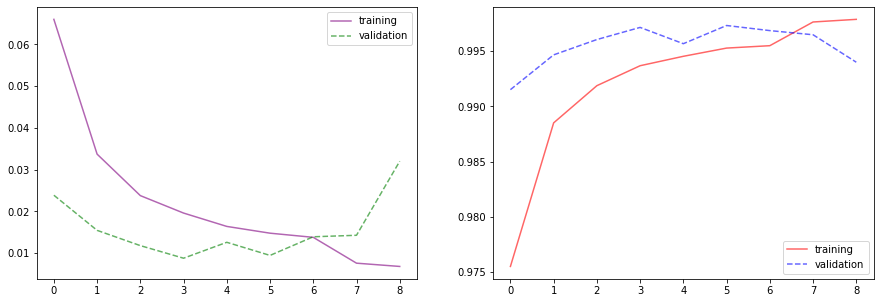

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(cnn_training_loss))),
             y = cnn_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(cnn_val_loss))),
             y = cnn_val_loss, color = 'green', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(cnn_training_loss))),
             y = cnn_training_accuracy, color='r', alpha = 0.6, label='training',ax = ax2)
sns.lineplot(x = list(range(len(cnn_val_loss))),
             y = cnn_val_accuracy, color = 'b', alpha = 0.6, linestyle = 'dashed', label = 'validation',ax = ax2)
plt.savefig('img/cnn_loss_acc')
ax1.legend();